# Exploratory Analysis of Bike Data
In this project I will explore bike data from Ford GoBikes. I will focus on operational questions such as, how long are customers riding bikes, which stations are frequented the most, and if we can re-allocate bikes during the day where should we move bikes to? I'll try to learn as much as possible about how people use bikes using mainly plots

## Setup

In [2]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [3]:
# Load dataset
bikes = pd.read_csv('2017-fordgobike-tripdata.csv')
bikes.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [4]:
bikes.info()
bikes.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB


(519700, 15)

In [5]:
bikes.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,453159.000000
mean,1099.009521,95.034245,37.771653,-122.363927,92.184041,37.771844,-122.363236,1672.533079,1980.404787
std,3444.146451,86.083078,0.086305,0.105573,84.969491,0.086224,0.105122,971.356959,10.513488
min,61.000000,3.000000,37.317298,-122.444293,3.000000,37.317298,-122.444293,10.000000,1886.000000
25%,382.000000,24.000000,37.773492,-122.411726,23.000000,37.774520,-122.410345,787.000000,1974.000000
50%,596.000000,67.000000,37.783521,-122.398870,66.000000,37.783830,-122.398525,1728.500000,1983.000000
75%,938.000000,139.000000,37.795392,-122.391034,134.000000,37.795392,-122.391034,2520.000000,1988.000000
max,86369.000000,340.000000,37.880222,-121.874119,340.000000,37.880222,-121.874119,3733.000000,1999.000000


## Cleaning
##### Making a copy
First I want to make a copy of the data set so we can reference in case we make any changes we want to undo.

In [6]:
bikes_clean = bikes.copy()

##### Add 'duration_min' column
Then I'll add a new column for duration in minutes for easy to read interpretation of trip duration.

In [7]:
bikes_clean['duration_min'] = bikes_clean['duration_sec']/60
bikes_clean.duration_min.describe()

count    519700.000000
mean         18.316825
std          57.402441
min           1.016667
25%           6.366667
50%           9.933333
75%          15.633333
max        1439.483333
Name: duration_min, dtype: float64

##### Rearrange columns for visibility
Finally, I'll rearrange the columns a bit so the information I'm more interested in is closer to the left. We'll move the gps info all the way to the right and try to make use of that at a later time.

In [8]:
bikes_clean.columns
bikes_clean = bikes_clean[['duration_sec', 'duration_min', 'start_time', 'end_time', 'start_station_id',
       'start_station_name',  'end_station_id', 'end_station_name', 'bike_id', 'user_type', 'member_birth_year', 
        'member_gender', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']]
bikes_clean.head()

,duration_sec,duration_min,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,80110,1335.166667,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,43,San Francisco Public Library (Grove St at Hyde...,96,Customer,1987.0,Male,37.776435,-122.426244,37.778768,-122.415929
1,78800,1313.333333,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,96,Dolores St at 15th St,88,Customer,1965.0,Female,37.784872,-122.400876,37.766210,-122.426614
2,45768,762.800000,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,245,Downtown Berkeley BART,1094,Customer,NaN,NaN,37.870348,-122.267764,37.870348,-122.267764
3,62172,1036.200000,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,5,Powell St BART Station (Market St at 5th St),2831,Customer,NaN,NaN,37.774520,-122.409449,37.783899,-122.408445
4,43603,726.716667,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,247,Fulton St at Bancroft Way,3167,Subscriber,1997.0,Female,37.868813,-122.258764,37.867789,-122.265896


In [9]:
bikes_clean.start_station_name.value_counts()

San Francisco Ferry Building (Harry Bridges Plaza)                 15187
The Embarcadero at Sansome St                                      13664
San Francisco Caltrain (Townsend St at 4th St)                     12546
San Francisco Caltrain Station 2  (Townsend St at 4th St)          12055
Market St at 10th St                                               11960
Montgomery St BART Station (Market St at 2nd St)                   11334
Berry St at 4th St                                                 10956
Powell St BART Station (Market St at 4th St)                       10142
Howard St at Beale St                                               9926
Steuart St at Market St                                             9347
Powell St BART Station (Market St at 5th St)                        7987
Embarcadero BART Station (Beale St at Market St)                    7649
2nd St at Townsend St - Coming Soon                                 6605
3rd St at Townsend St                              

## Univariate Exploration

#### Bike Rental Duration

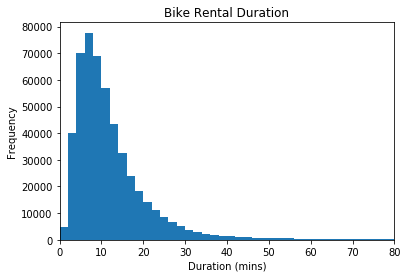

In [10]:
bin_edges = np.arange(0, bikes_clean['duration_min'].max()+50, 2)
plt.hist(data = bikes_clean, x = 'duration_min', bins=bin_edges)
plt.xlim(0, 80)
plt.title('Bike Rental Duration')
plt.xlabel('Duration (mins)')
plt.ylabel('Frequency');

#### Gender as a Proportion

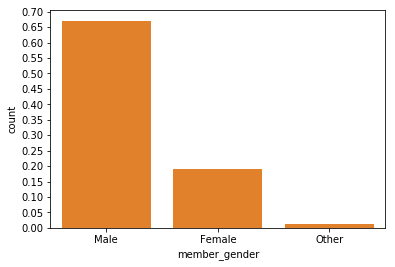

In [37]:
n_points = bikes_clean.shape[0]
max_count = bikes_clean['member_gender'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[1]
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('Proportion')
plt.xlabel('Member Gender')
sb.countplot(data = bikes_clean, x = 'member_gender', color = base_color);

#### Age Distribution

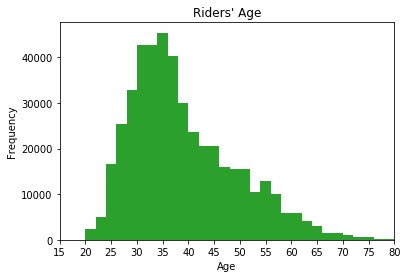

In [38]:
base_color = sb.color_palette()[2]
bikes_clean['age'] = 2019 - bikes['member_birth_year']
bin_edges = np.arange(0, bikes_clean['age'].max()+1, 2)
plt.hist(data = bikes_clean, x = 'age', bins=bin_edges, color = base_color)
plt.xticks([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
plt.xlim(0, 80)
plt.title("Riders' Age")
plt.xlabel('Age')
plt.xlim(15, 80) # Riders need to be at least 18 to use program
plt.ylabel('Frequency');

## Bivariate Exploration